In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib

import gensim

from nltk.corpus import stopwords,wordnet

from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.feature_extraction import text
sk_learn_stopwords = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
nltk__stopwords =   stopwords.words('english')
stop_words =sk_learn_stopwords.intersection(nltk__stopwords)

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [4]:
class CleanText(BaseEstimator, TransformerMixin):
    
    def __init__(self,stop_words,stemmer):
        self.stop_words = stop_words
        self.stemmer = stemmer
        
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)

    def remove_accented_chars(self,input_text):
        text = unicodedata.normalize('NFKD', input_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):

        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in self.stop_words or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
  
    def remove_repeated_characters(self,input_text):
        
        repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
        match_substitution = r'\1\2\3'
        tokens = input_text.split() 
        def replace(old_word):
            if wordnet.synsets(old_word):
                return old_word
            new_word = repeat_pattern.sub(match_substitution, old_word)
            return replace(new_word) if new_word != old_word else new_word
        correct_tokens = [replace(word) for word in tokens]
        
        return " ".join(correct_tokens)

    def stemming(self, input_text):
        #porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [self.stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_accented_chars)
        clean_X = clean_X.apply(self.remove_mentions)
        clean_X = clean_X.apply(self.remove_urls)
        clean_X = clean_X.apply(self.emoji_oneword)
        clean_X = clean_X.apply(self.remove_punctuation)
        clean_X = clean_X.apply(self.remove_digits)
        clean_X = clean_X.apply(self.remove_repeated_characters)
        clean_X = clean_X.apply(self.to_lower)
        clean_X = clean_X.apply(self.remove_stopwords)
        
        clean_X = clean_X.apply(self.stemming)
        return clean_X

In [5]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [6]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

def grid_vect(clf, parameters_clf, X_train,y_train, X_test,y_test ,parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)), 
                                 ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_tweet')), ('vect', vect)]))
                                ]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    
    if parameters_clf:
        parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [7]:
train_df = pd.read_csv('train.csv')

In [8]:
test_df = pd.read_csv('test.csv')

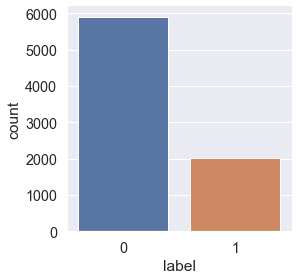

In [9]:
target_dist = sns.factorplot(x="label", data=train_df, kind="count", size=4)

In [10]:
tc = TextCounts()
df_eda  = tc.fit_transform(train_df['tweet'])
df_eda['label'] = train_df['label']

In [11]:
df_eda_test  = tc.fit_transform(test_df['tweet'])

In [12]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='label', size=4, hue='label', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
        count       mean       std  min   25%   50%   75%   max
label                                                          
0      5894.0  20.091279  6.633338  1.0  16.0  18.0  21.0  60.0
1      2026.0  18.782330  5.346050  9.0  15.0  18.0  22.0  58.0


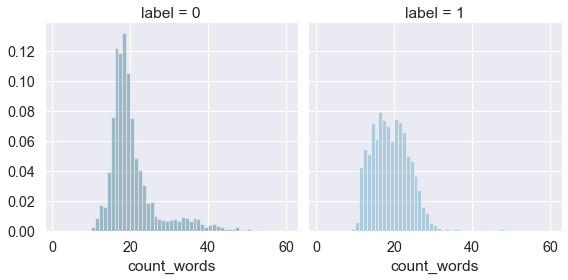

In [13]:
show_dist(df_eda, 'count_words')

In [14]:
df_eda[df_eda['count_words'].isin([60,58])]

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,label
1794,58,0,3,0,3,1,0,1
4494,60,0,15,2,0,1,0,0
4740,60,0,14,0,1,1,0,0


In [15]:
train_df.loc[df_eda[df_eda['count_words'].isin([1,9,60,58])].index]

,id,label,tweet
1794,1795,1,¿Me lo dices o me lo preguntas #Apple ? Ya mi teléfono funciona solo conectado a la electricidad. Do you tell me or do yo ask me #apple ? Now my iPhone works only connected.Have you asked yourself if you were in a bad economic situation could you pay a new phone? #apple https://twitter.com/el_interes/status/944881090115899392 …
1798,1799,1,End to End system. = $&@*# to $&@*# system! #Apple #MacBookPro #AppleIsShit
2156,2157,0,Got new iPhone !! :D Very Happy !! #Apple #iPhone @iPhoneTeam
2611,2612,1,@Eric_Can7ona: @SK77_M14 haha I thought s was for $&@*# hahahahahah
4494,4495,0,GT08 Bluetooth Smartwatch Smart Watch with SIM Card Slot and 2.0MP Camera for iPhone / Samsung and Android Phones https://a-jugni-sunita.myshopify.com/products/gt08-bluetooth-smartwatch-smart-watch-with-sim-card-slot-and-2-0mp-camera-for-iphone-samsung-and-android-phones … #Bluetooth #Smartwatch #Smart #Watch #SIM #Card #Slot #Camera #iPhone #Samsung #Android #Phones #sports #cute #pretty
4740,4741,0,"http://amazon.com/dp/B004CYKEBK?tag=amausrecman-20&_encoding=UTF8&tag=amausrecman-20&linkCode=ur2 … The #speaker #sounds good. I #plugged it into my #Samsung S5 and #there was no #distortion at the #highest #volume, #which I was #about. The new #batteries that were in it's #original new seal were dead on #arrival. Even with an #expiration date o…"
5253,5254,0,im going to instal my #sony vegas 11 now .. ;>
6340,6341,0,#ERROR!
6758,6759,1,@Bethanpie she broke her mac book :) :) except the ipods :)


Descriptive stats for count_mentions
------------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0      5894.0  0.156770  0.460034  0.0  0.0  0.0  0.0  6.0
1      2026.0  0.211254  0.520011  0.0  0.0  0.0  0.0  5.0


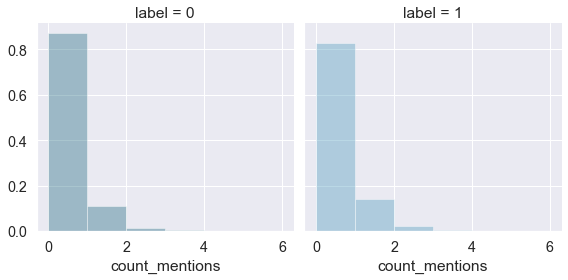

In [16]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5894.0  7.337801  4.857942  0.0  4.0  7.0  9.0  33.0
1      2026.0  1.788746  2.095920  0.0  0.0  1.0  2.0  26.0


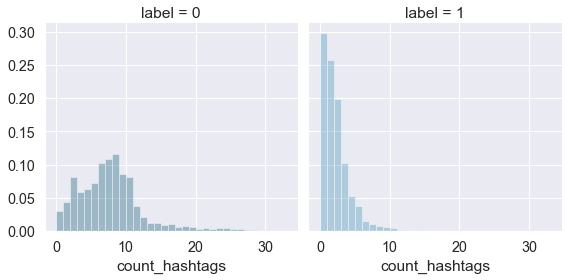

In [17]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5894.0  0.501188  1.480428  0.0  0.0  0.0  0.0  33.0
1      2026.0  0.524679  1.842337  0.0  0.0  0.0  0.0  25.0


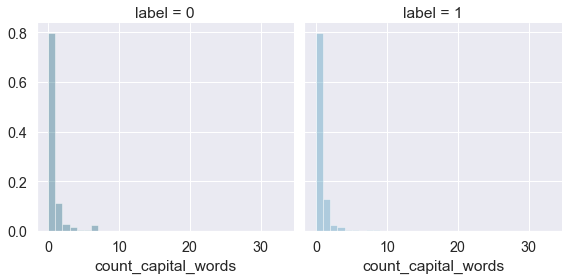

In [18]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5894.0  0.545470  1.097435  0.0  0.0  0.0  1.0  21.0
1      2026.0  0.637216  1.278571  0.0  0.0  0.0  1.0  13.0


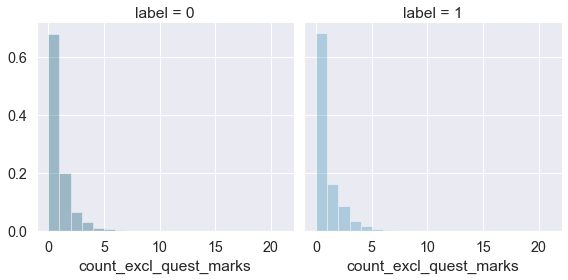

In [19]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0      5894.0  0.725484  0.498740  0.0  0.0  1.0  1.0  5.0
1      2026.0  0.101678  0.307161  0.0  0.0  0.0  0.0  3.0


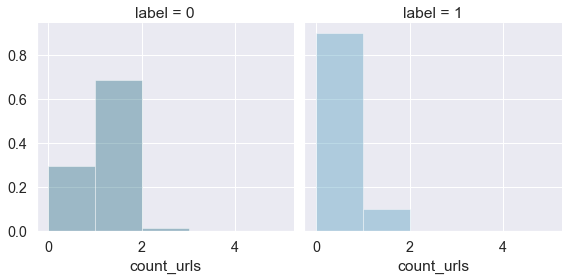

In [20]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
        count     mean       std  min  25%  50%  75%  max
label                                                    
0      5894.0  0.00017  0.013026  0.0  0.0  0.0  0.0  1.0
1      2026.0  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0


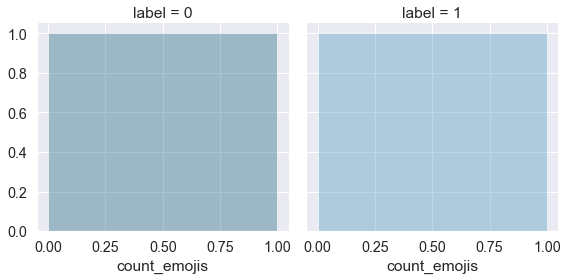

In [21]:
show_dist(df_eda, 'count_emojis')

In [22]:
stopwords  = stopwords.words('english')
other_stopwords = ['android','apple','appl','samsung','sony','galaxy',
                   'ipad','iphone','iphon','iphones','iphonex', 'ipod','itune','itun','itunes'
                   'phone','phon','twit','twitter']
stopwords.extend(other_stopwords)

In [23]:

porter_stemmer = PorterStemmer()
#ls = LancasterStemmer()
ct = CleanText(stopwords,porter_stemmer)
train_df['clean_tweet'] = ct.fit_transform(train_df['tweet'])
test_df['clean_tweet'] = ct.transform(test_df['tweet'])

In [24]:
train_clean = train_df['tweet'] == ''
train_df.loc[train_clean] = '[no_text]'

In [25]:
test_clean = test_df['tweet'] == ''
test_df.loc[test_clean] = '[no_text]'

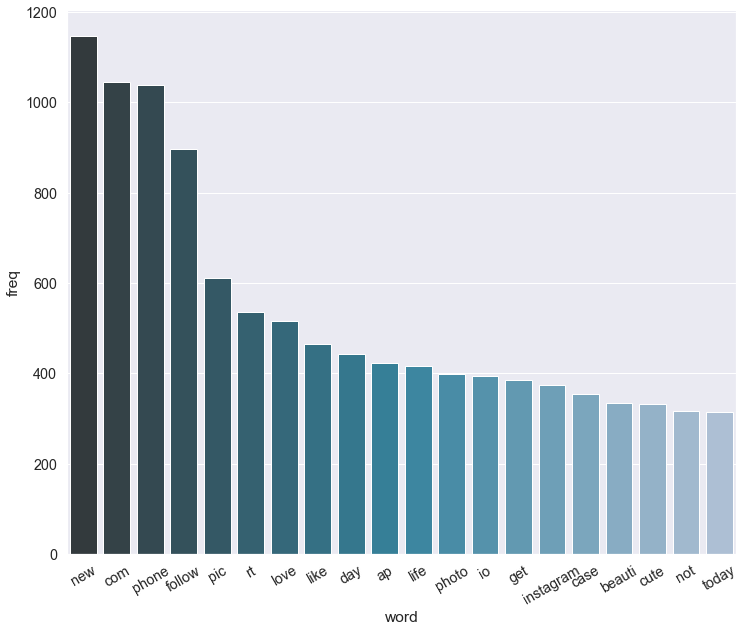

In [26]:
cv = CountVectorizer()
bow = cv.fit_transform(train_df['clean_tweet'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)

In [27]:
train_data = df_eda
train_data['clean_tweet'] = train_df['clean_tweet'] 

In [28]:
test_data = df_eda_test 
test_data['clean_tweet'] =test_df['clean_tweet'] 

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

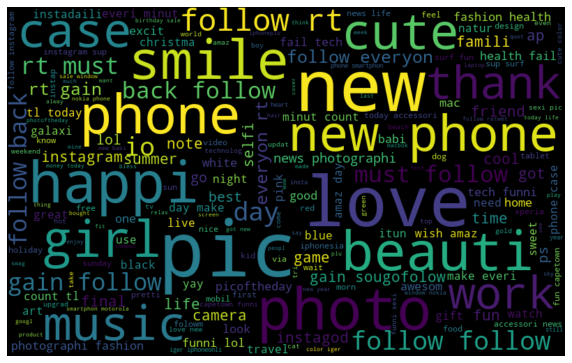

In [30]:
all_words_pos = ' '.join([text for text in train_data[train_data['label']==0]['clean_tweet'] ])
def plot_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    return plt
word_plt = plot_wordcloud(all_words_pos)
word_plt.show()

In [31]:
all_words_neg = ' '.join([text for text in train_data[train_data['label']==1]['clean_tweet'] ])

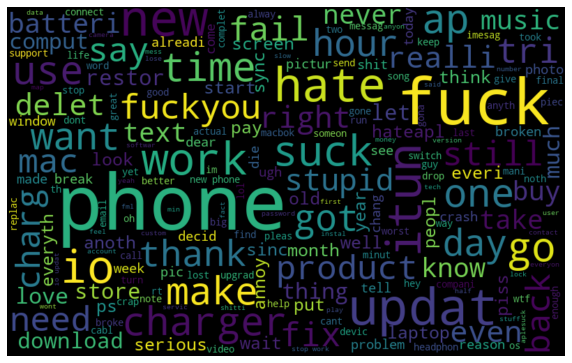

In [32]:
word_plt_neg = plot_wordcloud(all_words_neg)
word_plt_neg.show()

In [33]:
#ct.fit_transform(train_df['tweet'])
#train_df.info()
#ct.transform(train_df[train_df['id']==6]['tweet'])

In [34]:
train_df.to_csv('PreprocessedTrain.csv',index=False)

In [35]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
test_size = 0.15
seed = 42
kfold = StratifiedKFold(n_splits=5)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_data,train_df['label']  ,test_size=test_size,random_state=seed )

In [37]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75,0.9),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [38]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [39]:
countvect = CountVectorizer()

In [40]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train,y_train ,X_test,y_test ,
                               parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75, 0.9),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   46.0s finished


done in 52.470s

Best CV score: 0.894
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.907


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       877
           1       0.79      0.87      0.83       311

    accuracy                           0.91      1188
   macro avg       0.87      0.90      0.88      1188
weighted avg       0.91      0.91      0.91      1188



In [41]:
print(X_train.shape,  y_train.shape)
print(X_test.shape, y_test.shape)

(6732, 9) (6732,)
(1188, 9) (1188,)


In [43]:
SIZE = 25

X_train['clean_tweet_wordlist'] = X_train['clean_tweet'].apply(lambda x : word_tokenize(x))
X_test['clean_tweet_wordlist'] = X_test['clean_tweet'].apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train['clean_tweet_wordlist']
                 , min_count=1
                 , size=SIZE
                 , window=3
                 , workers=4)

In [44]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [45]:
X_train_w2v = X_train['clean_tweet_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_tweet_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [47]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
 

In [48]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train_w2v,y_train ,X_test_w2v,y_test ,
                              is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyError: "None of [Index(['count_capital_words', 'count_emojis', 'count_excl_quest_marks',\n       'count_hashtags', 'count_mentions', 'count_urls', 'count_words'],\n      dtype='object')] are in the [columns]"

In [ ]:
check

In [59]:
submission_df = test_df.copy()
submission_df.drop(['clean_tweet','tweet'],axis=1 ,inplace=True)
submission_df['label'] = y_pred
submission_df.to_csv('submission_Stacking_Latest.csv',index=False)